In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import bk.load
import bk.compute
import bk.signal

In [2]:
session_paths=['Z:\\Rat08\\Rat08-20130708',
 'Z:\\Rat08\\Rat08-20130709',
 'Z:\\Rat08\\Rat08-20130710',
 'Z:\\Rat08\\Rat08-20130711',
 'Z:\\Rat08\\Rat08-20130712',
 'Z:\\Rat08\\Rat08-20130713',
 'Z:\\Rat08\\Rat08-20130715',
 'Z:\\Rat08\\Rat08-20130716',
 'Z:\\Rat08\\Rat08-20130717',
 'Z:\\Rat08\\Rat08-20130718',
 'Z:\\Rat08\\Rat08-20130719',
 'Z:\\Rat09\\Rat09-20140324',
 'Z:\\Rat09\\Rat09-20140325',
 'Z:\\Rat09\\Rat09-20140326',
 'Z:\\Rat09\\Rat09-20140327',
 'Z:\\Rat09\\Rat09-20140328',
 'Z:\\Rat09\\Rat09-20140329',
 'Z:\\Rat09\\Rat09-20140331',
 'Z:\\Rat09\\Rat09-20140401',
 'Z:\\Rat09\\Rat09-20140402',
 'Z:\\Rat09\\Rat09-20140403',
 'Z:\\Rat09\\Rat09-20140404',
 'Z:\\Rat09\\Rat09-20140405',
 'Z:\\Rat09\\Rat09-20140407',
 'Z:\\Rat09\\Rat09-20140408',
 'Z:\\Rat09\\Rat09-20140409',
 'Z:\\Rat10\\Rat10-20140619',
 'Z:\\Rat10\\Rat10-20140620',
 'Z:\\Rat10\\Rat10-20140622',
 'Z:\\Rat10\\Rat10-20140624',
 'Z:\\Rat10\\Rat10-20140626',
 'Z:\\Rat10\\Rat10-20140627',
 'Z:\\Rat10\\Rat10-20140628',
 'Z:\\Rat10\\Rat10-20140629',
 'Z:\\Rat10\\Rat10-20140701',
 'Z:\\Rat10\\Rat10-20140702',
 'Z:\\Rat10\\Rat10-20140703',
 'Z:\\Rat10\\Rat10-20140704',
 'Z:\\Rat10\\Rat10-20140705',
 'Z:\\Rat10\\Rat10-20140707',
 'Z:\\Rat10\\Rat10-20140708',
 'Z:\\Rat11\\Rat11-20150310',
 'Z:\\Rat11\\Rat11-20150312',
 'Z:\\Rat11\\Rat11-20150313',
 'Z:\\Rat11\\Rat11-20150314',
 'Z:\\Rat11\\Rat11-20150315',
 'Z:\\Rat11\\Rat11-20150316',
 'Z:\\Rat11\\Rat11-20150317',
 'Z:\\Rat11\\Rat11-20150321',
 'Z:\\Rat11\\Rat11-20150323',
 'Z:\\Rat11\\Rat11-20150325',
 'Z:\\Rat11\\Rat11-20150326',
 'Z:\\Rat11\\Rat11-20150328',
 'Z:\\Rat11\\Rat11-20150330',
 'Z:\\Rat11\\Rat11-20150331',
 'Z:\\Rat11\\Rat11-20150401',
 'Z:\\Rat11\\Rat11-20150402',
 'Z:\\Rat11\\Rat11-20150403']

In [3]:
def split_neurons_types_regions(path, brain_region):
    bk.load.current_session(path)
    neurons, metadata = bk.load.loadSpikeData(path)
    pyramidal = neurons[(metadata['Type']=='Pyr') & (metadata['Region']==brain_region)]
    interneurons = neurons[(metadata['Type']=='Int') & (metadata['Region']==brain_region)]
    other_neurons = neurons[metadata['Type']=='Unk']
    return pyramidal, interneurons, other_neurons

In [4]:
def get_firing_rate_for_specific_state(neurons, state):
    """
    Returns a pandas Series object with the mean firing rate of each of the neurons during a chosen state (REM, sws, drowsy, or wake)
    
    Keyword arguments:
    neurons -- numpy.ndarray containing series data of selected neurons 
    state -- string, should be one of the following: Rem, sws, drowsy, wake (default='REM')
    
    Restrictions:
    Can only be called when the neurons and session have already been loaded.
    """
    mean_firing_rates = pd.Series(index = np.arange(len(neurons)),dtype='float64')
    state_used = bk.load.states()[state]

    for i in range(len(neurons)):
        try:
            spk_time = neurons[i].restrict(state_used).as_units('ms').index.values
            mean_firing_rates[i] = len(spk_time)/state_used.tot_length('s')
        except Exception:
            pass #using this exeption because not all neurons have spikes in all states. The nan values cannot be used to calculate firing rates.
    return mean_firing_rates

In [5]:
def get_FR_per_state_neurontype(path, states, brain_region):
    '''
    Returns 2 lists (one for each state) with the mean firing rate of each of the types of neurons (Pyramidal, interneurons, unknown) during the chosen state.
    
    Keyword arguments:
    path -- string containing the dircetory where the data files are stored
    states -- list of 2 strings, should be one of the following: REM, sws, drowsy, wake (default='REM')
    '''
    neurons_by_type=split_neurons_types_regions(path, brain_region)
    firing_rates_state0=[]
    firing_rates_state1=[]
    for i in neurons_by_type:
        x=get_firing_rate_for_specific_state(i, states[0])
        y=get_firing_rate_for_specific_state(i, states[1])
        firing_rates_state0.append(x)
        firing_rates_state1.append(y)
    return firing_rates_state0, firing_rates_state1

In [6]:
def get_firing_rates_all_sessions(paths, states, brain_region):
    '''
    Returns N lists (one for each state) with the mean firing rate of each of the types of neurons (Pyramidal, interneurons, unknown) during the chosen state
    where N is the number of sessions.
    Returned lists structure = Number of sessions * number of types of cells(=3) * number of cells(depends on session)
    
    Keyword arguments:
    paths -- list of strings containing the dircetories where the data files for each sessions are stored
    states -- list of 2 strings, should be one of the following: REM, sws, drowsy, wake (default='REM')
    '''
    
    all_sessions_state0=[]
    all_sessions_state1=[]

    for path in paths:
        FR_per_cell_state0,FR_per_cell_state1=get_FR_per_state_neurontype(path, states, brain_region)
        all_sessions_state0.append(FR_per_cell_state0)
        all_sessions_state1.append(FR_per_cell_state1)
    return np.array(all_sessions_state0,dtype=object), np.array(all_sessions_state1,dtype=object)

In [7]:
def double_flatten(array):
    flat_1=np.concatenate(array).ravel()
    flat_2=np.concatenate(flat_1).ravel()
    return flat_2

In [8]:
def plot_scatter(paths, states, brain_region):
    x,y=get_firing_rates_all_sessions(paths, states, brain_region)
    identity=np.linspace(-10,100,101) 
    plt.plot(identity,identity, 'k-', color='b')
    for i in range(len(x)):
        plt.scatter(x[i][2],y[i][2], color='gray', label='other cells')
        plt.scatter(x[i][0],y[i][0], color='r')
        plt.scatter(x[i][1],y[i][1], color='b')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(f'{states[0]} rate (Hz)')
    plt.ylabel(f'{states[1]} rate (Hz)')
    plt.show()

In [9]:
def plot_histogram(data, bin_size=50, upper_axis_bound=100, lower_axis_bound=0.1):
    other,inter,pyr=np.hsplit(data,3)
    pyr=double_flatten(pyr)
    inter=double_flatten(inter)
    other=double_flatten(other)
    logbins = np.logspace(np.log10(lower_axis_bound),np.log10(upper_axis_bound),bin_size)
    plt.hist(other, logbins, color='gray')
    plt.xscale('log')
    plt.hist(pyr, logbins, color='r')
    plt.xscale('log')
    plt.hist(inter, logbins, color='b')
    plt.xscale('log')
    plt.show()

In [10]:
def plot_both_histograms(paths, states, brain_region,bin_size=50, upper_axis_bound=100, lower_axis_bound=0.1):
    x,y=get_firing_rates_all_sessions(paths, states, brain_region)
    histogram_region_1=plot_histogram(x)
    histogram_region_2=plot_histogram(y)


In [12]:
x,y=get_firing_rates_all_sessions(session_paths[5:7], ['sws','wake'], 'BLA')

Rat : 8 on day : 6
Working with session Rat08-20130713 @ Z:\Rat08\Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy
Rat : 8 on day : 7
Working with session Rat08-20130715 @ Z:\Rat08\Rat08-20130715
Data already saved in Numpy format, loading them from here:
Rat08-20130715-neurons.npy
Rat08-20130715-metadata.npy


Rat : 8 on day : 6
Working with session Rat08-20130713 @ Z:\Rat08\Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy
Rat : 8 on day : 7
Working with session Rat08-20130715 @ Z:\Rat08\Rat08-20130715
Data already saved in Numpy format, loading them from here:
Rat08-20130715-neurons.npy
Rat08-20130715-metadata.npy
Rat : 8 on day : 8
Working with session Rat08-20130716 @ Z:\Rat08\Rat08-20130716
Data already saved in Numpy format, loading them from here:
Rat08-20130716-neurons.npy
Rat08-20130716-metadata.npy
Rat : 8 on day : 9
Working with session Rat08-20130717 @ Z:\Rat08\Rat08-20130717
Data already saved in Numpy format, loading them from here:
Rat08-20130717-neurons.npy
Rat08-20130717-metadata.npy
Rat : 8 on day : 10
Working with session Rat08-20130718 @ Z:\Rat08\Rat08-20130718
Data already saved in Numpy format, loading them from here:
Rat08-20130718-neurons.npy
Rat08-20130718-metadata.npy
Rat : 8 on day : 11

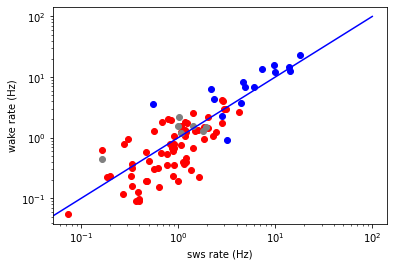

In [17]:
h=plot_scatter(session_paths[5:19], ['sws','wake'], 'Hpc')

Rat : 8 on day : 6
Working with session Rat08-20130713 @ Z:\Rat08\Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy
Rat : 8 on day : 7
Working with session Rat08-20130715 @ Z:\Rat08\Rat08-20130715
Data already saved in Numpy format, loading them from here:
Rat08-20130715-neurons.npy
Rat08-20130715-metadata.npy
Rat : 8 on day : 8
Working with session Rat08-20130716 @ Z:\Rat08\Rat08-20130716
Data already saved in Numpy format, loading them from here:
Rat08-20130716-neurons.npy
Rat08-20130716-metadata.npy
Rat : 8 on day : 9
Working with session Rat08-20130717 @ Z:\Rat08\Rat08-20130717
Data already saved in Numpy format, loading them from here:
Rat08-20130717-neurons.npy
Rat08-20130717-metadata.npy
Rat : 8 on day : 10
Working with session Rat08-20130718 @ Z:\Rat08\Rat08-20130718
Data already saved in Numpy format, loading them from here:
Rat08-20130718-neurons.npy
Rat08-20130718-metadata.npy
Rat : 8 on day : 11

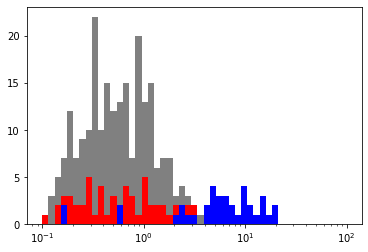

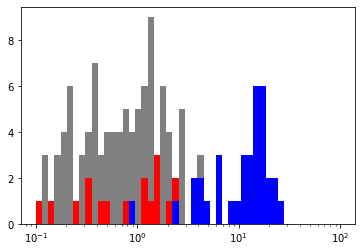

In [18]:
plot_both_histograms(session_paths[5:29], ['sws','wake'], 'Hpc',bin_size=50, upper_axis_bound=100, lower_axis_bound=0.1)